# Lab 6: MNIST with CNN Model

## 1. Download the MNIST Dataset
• Download the MNIST dataset using PyTorch's torchvision.datasets module.
Hint: from torchvision.datasets import MNIST

• Save the dataset in a format that can be accessed throughout your notebook

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from PIL import Image
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from scipy import ndimage
import scipy.misc
from scipy import ndimage
import matplotlib.pyplot as plt

In [4]:
# download  MNIST dataset 
from torchvision.datasets import MNIST

## 2. Prepare the Data

### 2.1 Introduce the MNIST Dataset
* Write a brief explanation about the MNIST dataset in your Jupyter Notebook.
*  Include details such as:
* The size of the dataset.
* Number of classes (digits 0-9).
* Your Image dimensions

In [7]:

#The MNIST dataset we're working with in this lab contains 60,000 sample images, 
# 10,000 of which are test samples.
# It has 10 classes, one for each digit 0-9, and image dimensions of 28 x 28



### 2.2 Create a Dataset and DataLoader
* Create a PyTorch Dataset to handle the raw MNIST data.
* Use a PyTorch DataLoader to manage batching for your data.

In [9]:
# preprocess data via convert image to tensor 
# download  MNIST dataset 
from torchvision.datasets import MNIST
import torchvision.transforms as transforms #jupyter forgot i imported this because jupyter is stupid.

transform = transforms.Compose([transforms.ToTensor(), #docs say i gotta use a decimal, image is 28*28
                                transforms.Normalize((0.28,), (0.28,))]) #so why not

# download MNIST test and train data
test_data = MNIST(root='./data', train=False, download=True, transform=transform)
train_data = MNIST(root='./data', train=True, download=True, transform=transform)

In [10]:
# dataloaders for loading shuffled test training data into 64 batches
test_loader = DataLoader(test_data, 64, False)
# data, batch_size, shuffle (randomly reorders dataset on iter)
train_loader = DataLoader(train_data, 64, True)

### 2.3 Preprocess the Data
* Apply necessary transforms (e.g., normalization, resizing) to preprocess the data.
* Use PyTorch’s torchvision.transforms or other preprocessing methods.
* Clearly explain why the preprocessing steps were necessary

In [12]:
#Clearly explain why the preprocessing steps were necessary


# preprocessing is a necessary step in creating a neural network model (or really any learning model), 
#as it ensures the model is receiving the correct data, in the correct formmating for it to work with. 

#In this example, the model in pytorch needs it's data to be input as tensors (a type of multidimensional array), 
# whereas it is initially image files.

In [13]:
# preprocess data via convert image to tensor 
transform = transforms.Compose([transforms.ToTensor(), #docs say i gotta use a decimal, image is 28*28
                                transforms.Normalize((0.28,), (0.28,))]) #so why not


### 2.4 Visualize the Processed Data
* Visualize a sample of the processed data (e.g., show a grid of images).
* Use appropriate titles for the visualizations to include your name.

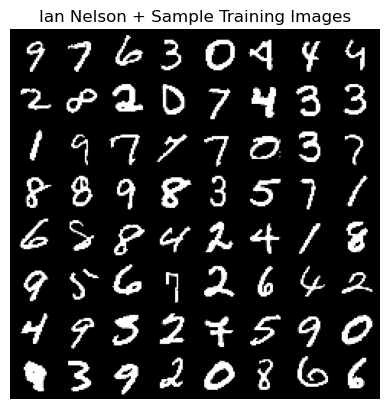

In [15]:
plt.title("Ian Nelson + Sample Training Images")
# get first batch of imgnumbers from the training loader
showImage = next(iter(train_loader))[0]
# ensures numbers are right side up
rotate = (1,2,0) 
plt.axis('off')
plt.imshow(np.clip(np.transpose(make_grid(showImage), rotate), 0, 1));



## 3. Build a CNN Model

### 3.1 Define the Model Structure
* Design your own CNN model with layers like convolutional layers, pooling layers,
and fully connected layers.
* The model must be implemented using PyTorch.

In [18]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        #conculution layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        #pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        #fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        #more pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 3.2 Set Up the Trainer
* Define a training loop that includes:
* A loss function (e.g., Cross-Entropy Loss).
* An optimizer (e.g., Adam or SGD).
* A learning rate scheduler (if applicable).

In [20]:
#define model, criterion, optimizer, and scheduler
model = CNNModel()
criterion = nn.CrossEntropyLoss() #I dont want this taking forever to run, 
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9) # .03 is the rate from the tensor demo site.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

### 3.3 Summarize Your Model
* Use torchsummary or other tools to display a summary of your CNN, showing:
* Layer names.
* Output dimensions for each layer.
* Total number of parameters.

In [22]:
# print model summary
print("Model Summary:", summary(CNNModel(), (1, 28, 28)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 128]         401,536
            Linear-6                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 1.61
Estimated Total Size (MB): 1.97
----------------------------------------------------------------
Model Summary: None


### 3.4 Train Your Model
* Train your model for multiple epochs (e.g., 50–100).
* Ensure that your model learns e[ectively by monitoring loss and accuracy during
training.

In [24]:
#Calculate the accuracy given model outputs and labels,returns num correct predics and total samples
# in fun to reuse code
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0) 
    correct = (predicted == labels).sum().item()
    return correct, total


# Training loop
# i'll see if i can run 50 overnight. 
# i'll settle for 5 for now
num_epochs = 100
test_losses, train_losses, test_accuracies, train_accuracies  = [] , [], [], []
 

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        # Backward pass
        loss = criterion(outputs, labels)
        loss.backward()
        # Update weights
        optimizer.step()
        
        # Calculate training accuracy
        correct_train, total_train = map(sum, zip((correct_train, total_train), calculate_accuracy(outputs, labels)))
        
        # Accumulate loss
        running_loss += loss.item()
    # Store training metrics
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)



    
    # Testing Loop
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            # Forward pass
            outputs = model(images)
            # Backward pass
            loss = criterion(outputs, labels)
            # Calculate loss
            test_loss += loss.item()
            
            # Calculate validation accuracy
            correct, total = map(sum, zip((correct, total), calculate_accuracy(outputs, labels)))
    
    # Store testing metrics
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct / total * 100)
    
    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_losses[-1]:.4f} - Test Loss: {test_losses[-1]:.4f}")
    print(f"Training Accuracy: {train_accuracies[-1]:.2f}% - Test Accuracy: {test_accuracies[-1]:.2f}%")
    
    #SGD schedualer needs to be updated
    scheduler.step()

Epoch 1/100 - Training Loss: 0.1383 - Test Loss: 0.0539
Training Accuracy: 95.66% - Test Accuracy: 98.17%
Epoch 2/100 - Training Loss: 0.0379 - Test Loss: 0.0425
Training Accuracy: 98.82% - Test Accuracy: 98.61%
Epoch 3/100 - Training Loss: 0.0254 - Test Loss: 0.0350
Training Accuracy: 99.22% - Test Accuracy: 98.96%
Epoch 4/100 - Training Loss: 0.0181 - Test Loss: 0.0324
Training Accuracy: 99.40% - Test Accuracy: 98.99%
Epoch 5/100 - Training Loss: 0.0124 - Test Loss: 0.0308
Training Accuracy: 99.56% - Test Accuracy: 99.17%
Epoch 6/100 - Training Loss: 0.0099 - Test Loss: 0.0300
Training Accuracy: 99.71% - Test Accuracy: 99.12%
Epoch 7/100 - Training Loss: 0.0077 - Test Loss: 0.0341
Training Accuracy: 99.78% - Test Accuracy: 99.00%
Epoch 8/100 - Training Loss: 0.0046 - Test Loss: 0.0378
Training Accuracy: 99.84% - Test Accuracy: 99.07%
Epoch 9/100 - Training Loss: 0.0071 - Test Loss: 0.0329
Training Accuracy: 99.74% - Test Accuracy: 99.15%
Epoch 10/100 - Training Loss: 0.0047 - Test Lo

## 4. Visualize and Evaluation

### 4.1 Create at least 5 visualizations to evaluate/ Visualize the performance of your
model, such as (you can make your own choice):
* Training loss over epochs.
* Validation loss over epochs.
* Visualize predicted results and actual results.
* Validation accuracy over epochs.
* Confusion matrix or misclassified examples

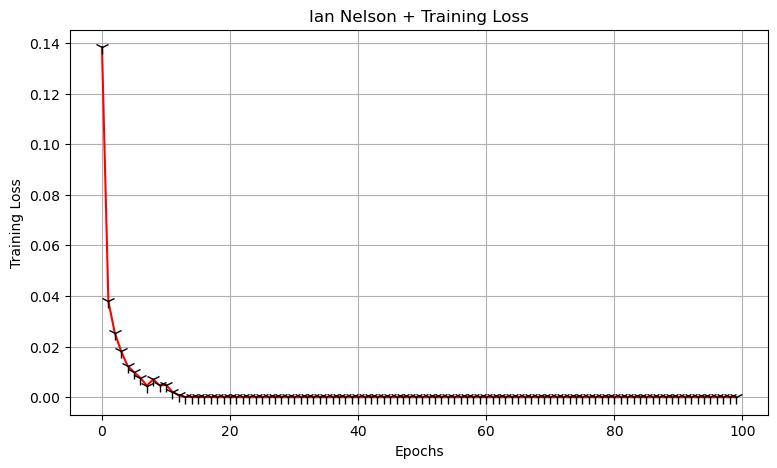

In [27]:
plt.figure(figsize=(9, 5))
plt.title("Ian Nelson + Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.grid()
plt.plot(train_losses, color='red', marker="1", markersize=10, markerfacecolor='black', markeredgecolor='black')
plt.show()

The graph above demonstrates a starting high loss, around 0.14, before dipping and approaching zero. 
This is an indication of effective learning accross the epochs of the model, as each successive epoch reduces training loss.
As such, this training can be concluded to have low loss.

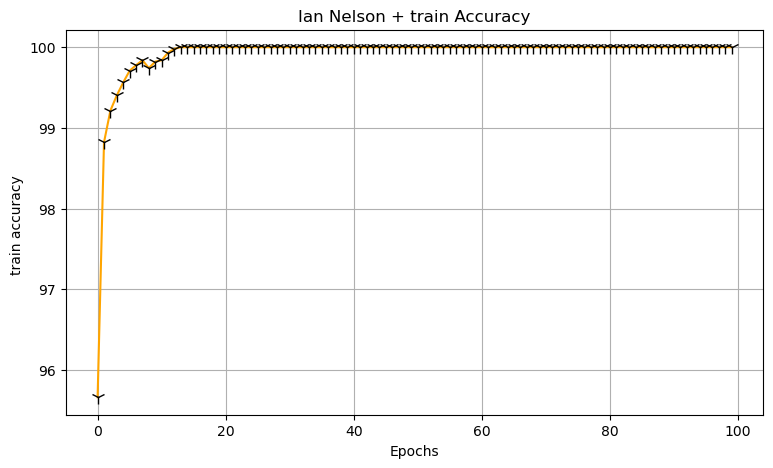

In [29]:
plt.figure(figsize=(9, 5))
plt.title("Ian Nelson + train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("train accuracy ")
plt.grid()
plt.plot(train_accuracies, color='orange', marker="1", markersize=10, markerfacecolor='black', markeredgecolor='black')
plt.show()



The graph above demonstrates an initial low (relatively) accuracy rate of around 95 (i may re-run the model, so it may change), 
gradually rising to a rough plateau around 99%
This is also an indication of effective trained learning accross the epochs of the model, as each successive epoch reduces innacuracy.
As such, this model can be concluded to be extremely accurate.

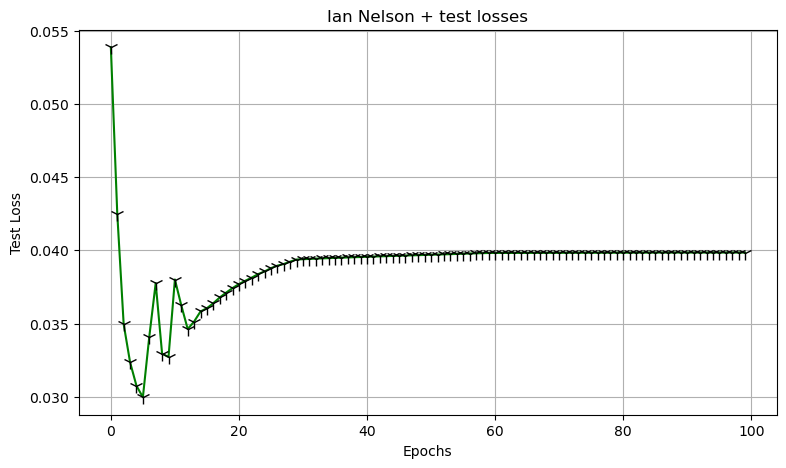

In [31]:
plt.figure(figsize=(9, 5))
plt.title("Ian Nelson + test losses")
plt.xlabel("Epochs")
plt.ylabel("Test Loss")
plt.grid()
plt.plot(test_losses, color='green', marker="1", markersize=10, markerfacecolor='black', markeredgecolor='black')
plt.show()

Within the figure above, the test loss curve displays a starting loss of around 0.055 before decreasing to a low of 0.03, before bouncing back to 0.04. I don't actually know what could have caused the loss to go up again before plateauing. THis is not reflected in the training loss, or test accuracy.

As this is the data used to test the model after training it, it is as expected to both start and end much lower
than the curve of the training loss. 
The decrease in loss is an indication of effective learning accross the epochs of the model, as each successive epoch reduces innacuracy.
As such, this model can be concluded through testing to have minimal loss

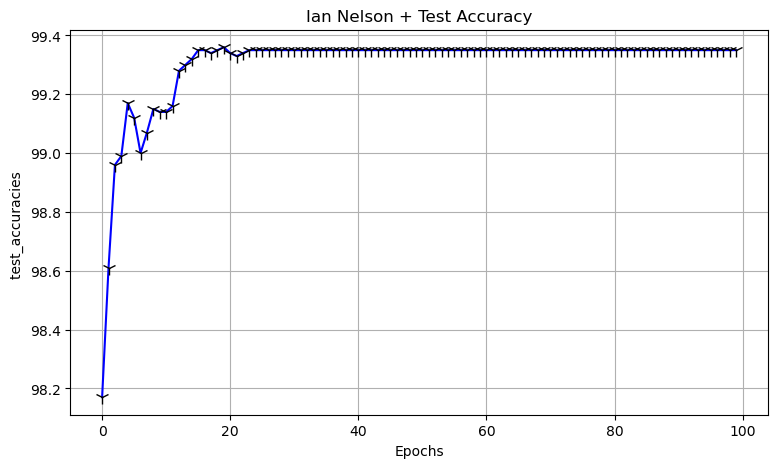

In [33]:
plt.figure(figsize=(9, 5))
plt.title("Ian Nelson + Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("test_accuracies ")
plt.grid()
plt.plot(test_accuracies, color='blue', marker="1", markersize=10, markerfacecolor='black', markeredgecolor='black')
plt.show()


Withing the figure above, the test accuracy starts (albiet higher than the start of the training data) at around 98.2%, before rising to 99.35%.
As this is the data used to test the model after training it, it is as expected to start higher than the curve of the training accuracy. 
The rise in accuracy is an indication of effective trained learning accross the epochs of the model, as each successive epoch reduces innacuracy.
As such, this model can be concluded through testing to be extremely accurate.

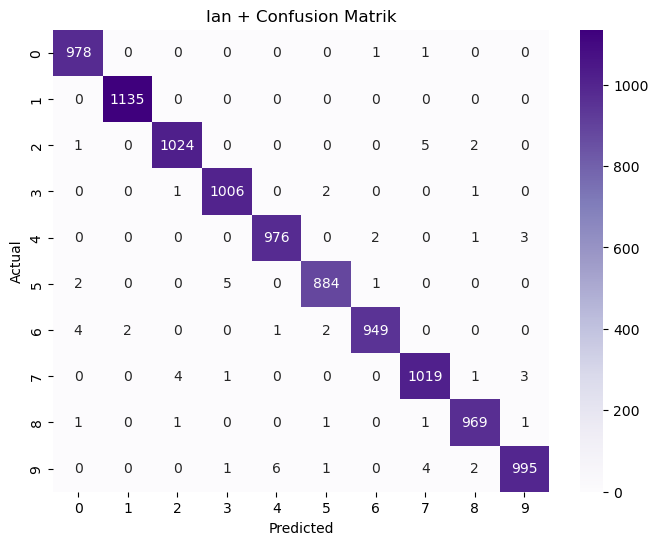

In [35]:
# Confusion Matrix
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Purples", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Ian + Confusion Matrik")
plt.show()




The confusion matrix above depitcs a solid correlation of each class to itself. Correct results are predicted hundreds of times, 
Whereas almost all incorrect predictions are chosen less than ten times, many of them at zero. 
The only exception is some precictions of 7's as 2's, and 9's as 4's. Likely because they resemble each other closer than other numbers.
The thousands of correct predictions show this model is quite accurate. 

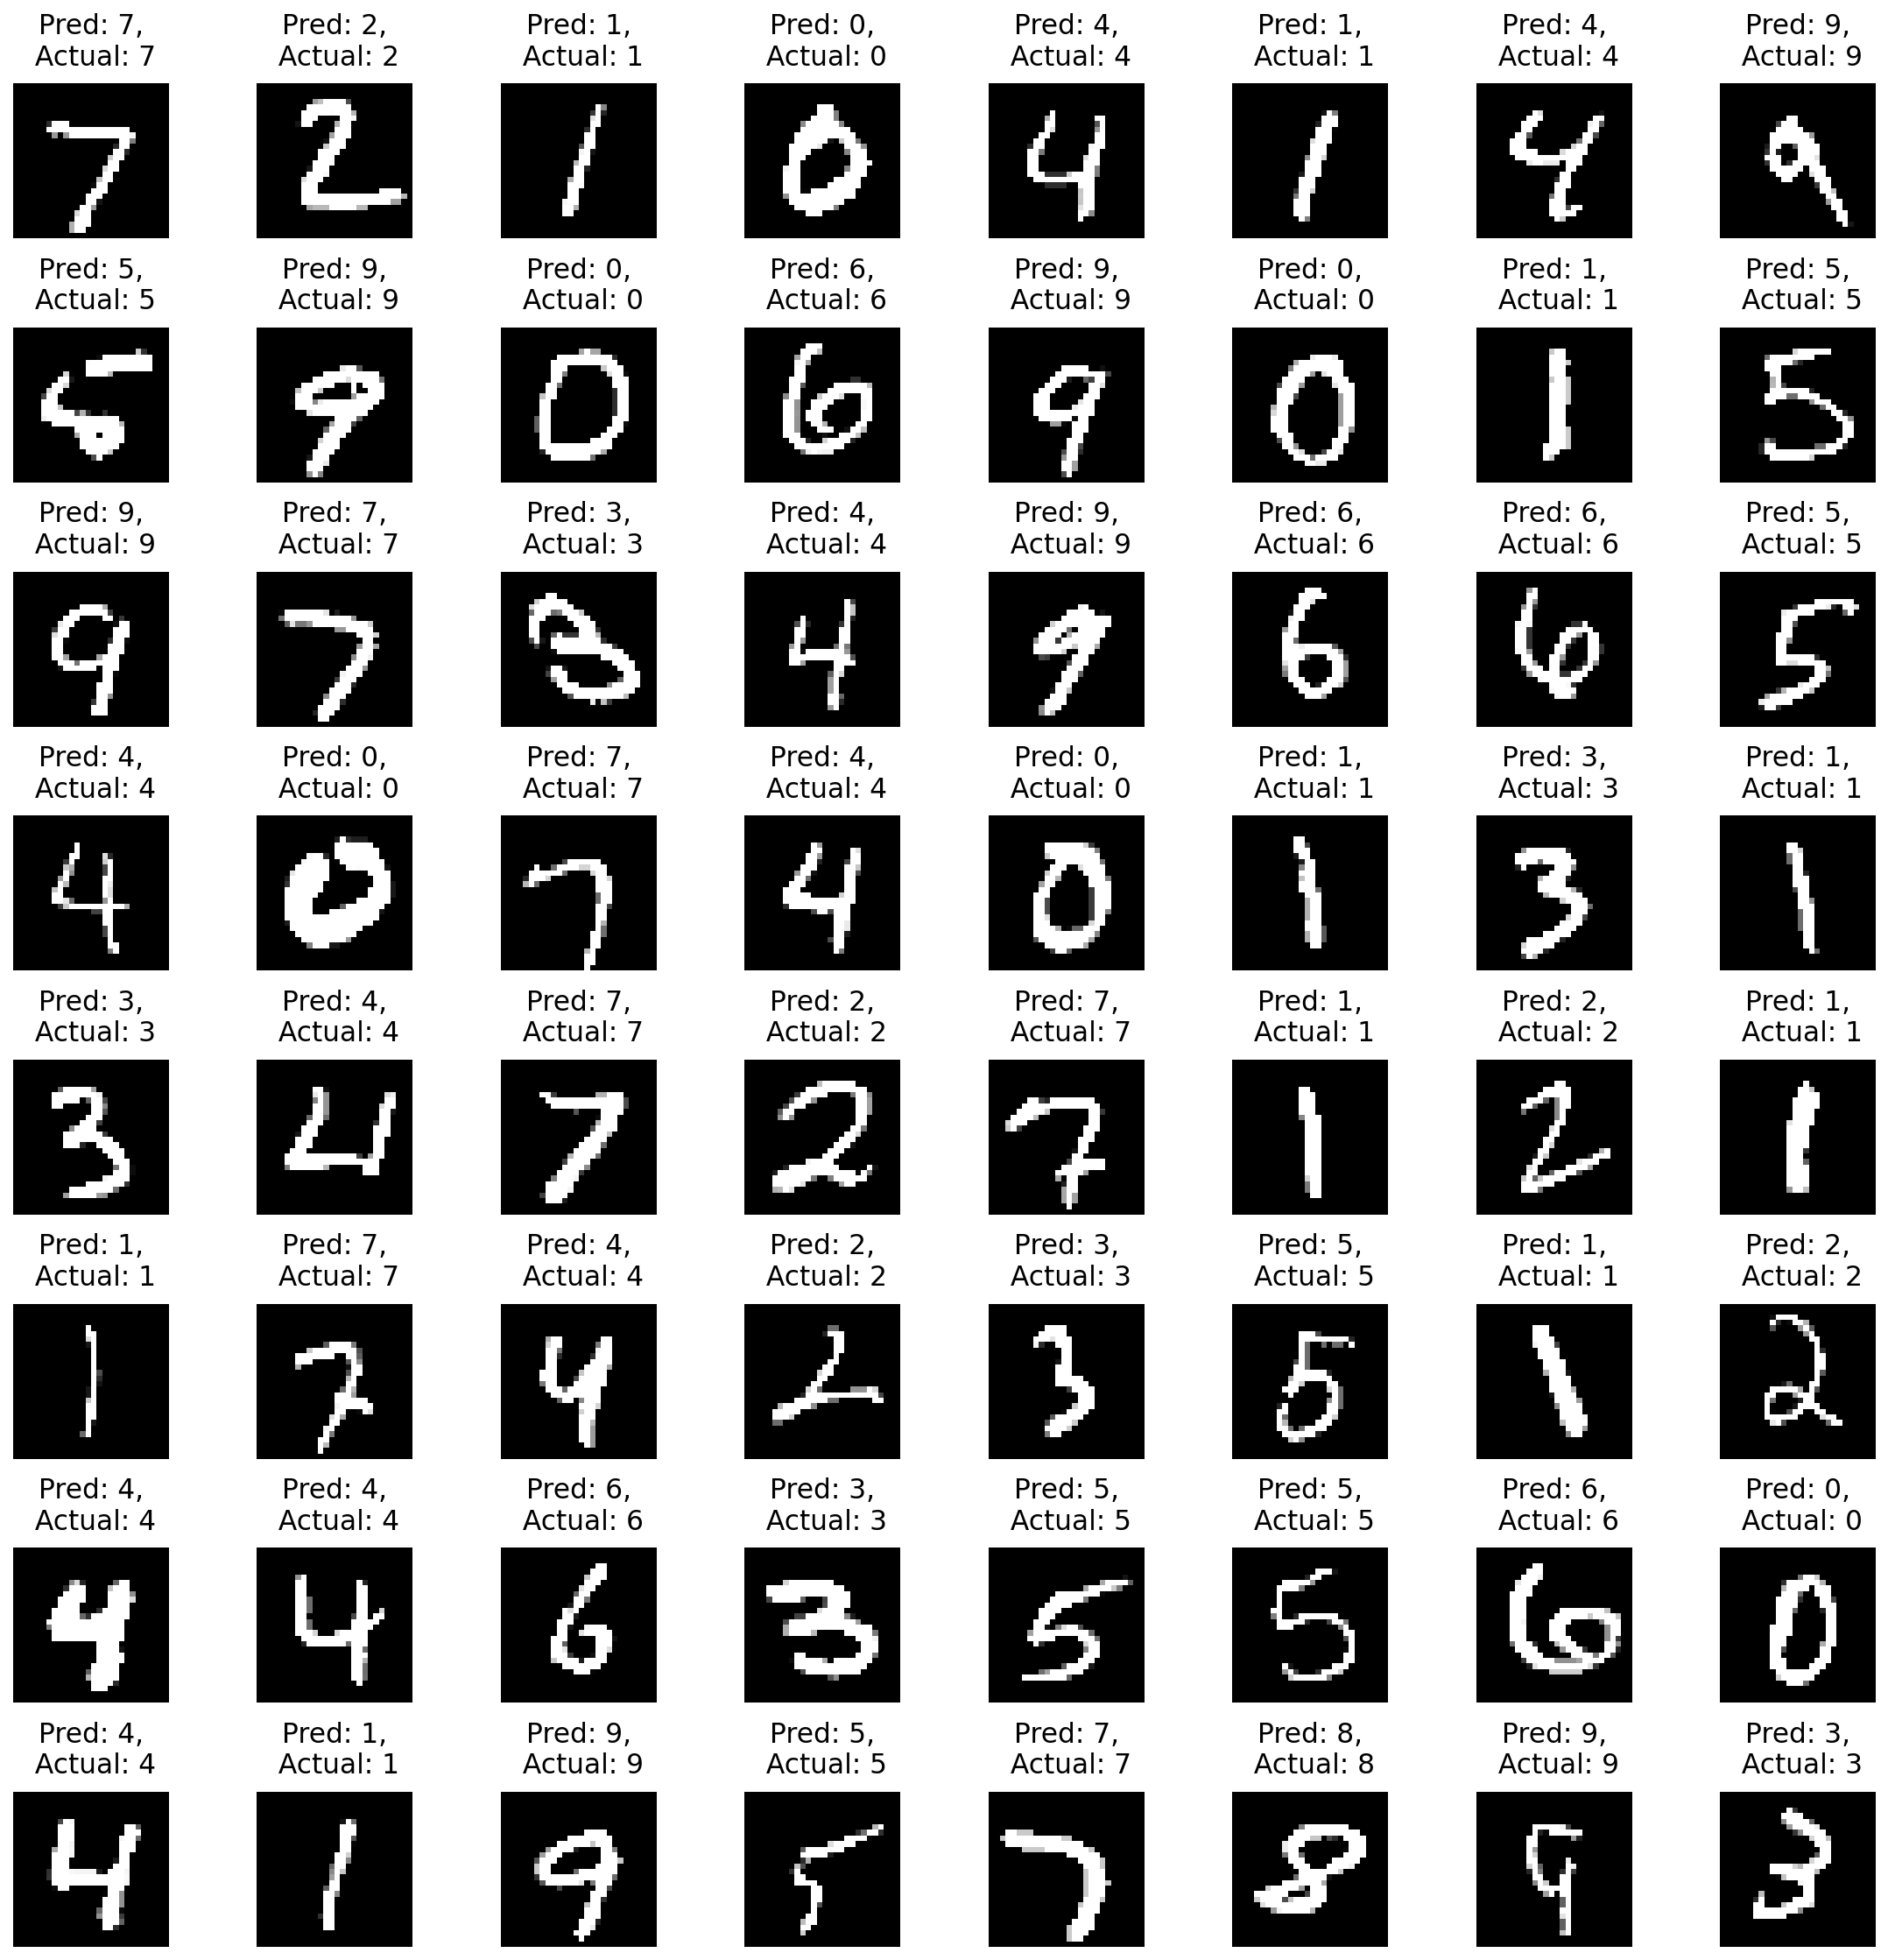

In [37]:
import torch as torch

# images from test set
showImage = next(iter(test_loader))

# Get predictions
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(showImage[0])
        _, predicted = torch.max(outputs, 1)
    
# Plot the images with predicted and actual labels
axes = plt.subplots(8, 8, figsize=(15, 15), dpi=150)[1]
# get first batch of imgnumbers from the training loader
for i, axis in enumerate(axes.flat):
    rotate = (1,2,0) # ensures numbers are right side up
    axis.axis('off') # shows the axis of the graph in a weird way
    #display the images and labels
    axis.imshow(np.clip(np.transpose(make_grid(showImage[0][i]), rotate), 0, 1));
    axis.set_title(f" Pred: {predicted[i].item()}, \n Actual: {showImage[1][i].item()}", fontsize=15, pad=10)

#increase spacing between images, its waaaay too small
plt.subplots_adjust(hspace=0.15, wspace=0.15)  
plt.tight_layout(pad=1)
plt.show()


As shown by a partial output (64 images), every single predicton is correct. 
As it's accuracy is not exactly 100%, there's a chance one of the output examples could be an incorrect prediction, 
but this is exceedingly unlikely. This further demonstrates the accuract of this model. 
As it stands, the model is extremely adept to pick digits out of the data provided, 
because some of these numbers are real weird looking.
Notably the 3 at (5, 2) looks very 8-ish, and the 5 at (6, 0) is very unclear. This demonstrates the successful learning of the neural network.

### 4.2 Save Model

In [40]:
torch.save(model.state_dict(), 'mymodel.pth')

### 4.3 Use text cells to explain your visualizations and analyze the quality of your model.
For example
* How well does your model perform on the test set?
* Are there patterns in the loss/accuracy curves (e.g., overfitting or
underfitting)?
* Which digits are most often misclassified?